In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from hodalpt.sims import alpt as CS
from hodalpt.sims import quijote as Q
from hodalpt import stats

ics = Q.IC('/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/0')
fconfig = '/Users/mcc3842/CosmicSim2025/CosmicSignal4SimBIG/boxes/config_file.ini'#'/Users/hahnchanghoon/projects/CosmicSignal4SimBIG/boxes/config_file.ini'
outdir = '/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/0/alpt/'

In [3]:
# HOD for quijote 
theta_hod = {
    'logMmin': 13.06,
    'sigma_logM': 0.34,
    'logM0': 13.74,
    'logM1': 14.17,
    'alpha': 0.69,
    'Abias': 0.1, 
    'eta_conc': 1.12,
    'eta_cen': 0.3,
    'eta_sat': 1.26}
hod_quijote = Q.HODgalaxies(theta_hod,'/Users/mcc3842/CosmicSim2025/data/quijote/latin_hypercube_HR/0', z=0.5)
# get redshift-space positions
xyz_q = Q.Box_RSD(hod_quijote, LOS=[0,0,1], Lbox=1000.) # in z-direction
hod_Q_spec = stats.Pk_periodic(xyz_q.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
k_bins_allk = hod_Q_spec['k']
P_nbody_allk = hod_Q_spec['p0k']
k_bins = k_bins_allk[:78:2]
P_nbody = P_nbody_allk[:78:2]

/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/phase_space_models/analytic_models/satellites/nfw/biased_nfw_phase_space.py:225: UserWarning: You have selected 18 bins to digitize host halo concentration 
and 96 bins to digitize the galaxy bias parameter.
To populate mocks, the BiasedNFWPhaseSpace class builds a lookup table with shape (18, 96, 101),
one entry for every numerical solution to the Jeans equation.
Using this fine of a binning requires a long pre-computation of 174528 integrals
.Make sure you actually need to use so many bins
  warn(lookup_table_performance_warning.format(*args))
/opt/homebrew/Caskroom/miniconda/base/envs/simbig/lib/python3.11/site-packages/halotools/empirical_models/factories/hod_model_factory.py:890: UserWarning: The composite model received multiple component models 
with a new_haloprop_func_dict that use the conc_NFWmodel key. 
Ignoring the one that appears in the profile component for satellite

------------------
67718 positions in 1000 box
nbar = 0.000068
67718 positions, Ntot=67718
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


In [ ]:
# Least squares to fit ALPT to n-body powspec
from scipy.optimize import minimize
xyz = CS.CSbox_alpt(fconfig, outdir, seed=0, make_ics=True, silent=False)
# Starting parameters
# theta_gal = {
#     'alpha': 1.9230,
#     'beta': 2.0253,
#     'dth': -0.7889,
#     'rhoeps': 14.6874,
#     'eps': 0.5616, 
#     'nmean': 3.3e-4
# }

# theta_rsd = {
#     'bv': 0.7289,
#     'bb': 1.1652,
#     'betarsd': 1.3136,
#     'gamma': 0.4944
# }
# Only fit bias model
theta_gal_free = {
    'alpha': (1.9230 + 0.5*1.923), # tune this ? 
    'beta': 2.0253,
    # 'dth': -0.7889,
    'rhoeps': 14.6874,
    'eps': 0.5616, 
    # 'nmean': 3.3e-4
}
theta_gal_fixed = {
    'dth': -0.7889,
    'nmean': 3.3e-4
}
# Keep RSD fixed at CMASS values
theta_rsd_fixed = {
    'bv': 0.7289,
    'bb': 1.1652,
    'betarsd': 1.3136,
    'gamma': 0.4944
}
param_names = list(theta_gal_free.keys())
theta_init = np.array(list(theta_gal_free.values()))

def make_bounds(val, fraction=0.5):
    delta = fraction * abs(val)
    return (val - delta, val + delta)

bounds = [make_bounds(val) for val in theta_init]

def run_alpt_and_measure_pk(theta_gal_dict, theta_rsd_dict):
    """
    Your function that:
    1. Takes parameter dictionary
    2. Runs ALPT simulation
    3. Measures P(k)
    4. Returns P_alpt at your k_bins
    """
    
    xyz_g = CS.CSbox_galaxy(theta_gal_dict, theta_rsd_dict, outdir, silent=True)
    alpt_spec = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
    kbins_alpt_allk = alpt_spec['k']
    P_alpt_allk = alpt_spec['p0k']
    return P_alpt_allk[:78]
    
# def params_array_to_dict(params_array):
#     """Convert parameter array back to dictionaries"""
#     theta_gal_new = {name: params_array[i] for i, name in enumerate(list(theta_gal.keys()))}
#     theta_rsd_new = {name: params_array[i+6] for i, name in enumerate(list(theta_rsd.keys()))}
#     return theta_gal_new, theta_rsd_new
def params_array_to_dict(params_array):
    """Convert parameter array to galaxy bias dictionary, combining free and fixed"""
    theta_gal_new = {name: params_array[i] for i, name in enumerate(param_names)}
    # Add back the fixed parameters
    theta_gal_new.update(theta_gal_fixed)
    return theta_gal_new

def chi_squared(params_array):
    """Objective function for minimizer"""
    # Convert array to dictionaries
    theta_gal_new = params_array_to_dict(params_array)
    
    # Run ALPT with these parameters
    P_alpt = run_alpt_and_measure_pk(theta_gal_new, theta_rsd_fixed)
    # Compute chi-squared (simple 1/P^2 weighting)
    weights = 1.0 / P_nbody**2
    chi2 = np.sum(weights * (P_nbody - P_alpt)**2)
    
    print(f"χ² = {chi2:.2f}")  # Monitor progress
    return chi2
# Run optimization
result = minimize(
    chi_squared,
    theta_init,
    method='L-BFGS-B',  # Good for bounded optimization
    bounds=bounds,
    options={'disp': True, 'maxiter': 10}
)
theta_best = result.x
theta_gal_best = params_array_to_dict(theta_best)

print("\nBest-fit parameters:")
print("Galaxy bias:", theta_gal_best)
# print("RSD:", theta_rsd_best)
print(f"Final χ² = {result.fun:.2f}")

Computing and writing out delta IC
Computing displacement fields at z=0.5
Compiled with MULTITHREAD support, with 10 threads
 >>> web-on: initialising settings....

---> attention: N1= 256
---> attention: redshift= 0


 >>> starting web-on  ...

 >>> web-on initialising cosmological model....

number of chosen redshift snapshots = 1
... writing file posx.dat
... writing file posy.dat
... writing file posz.dat
... writing file posorx.dat
... writing file posory.dat
... writing file posorz.dat
... writing file posor0x.dat
... writing file posor0y.dat
... writing file posor0z.dat
... reading file Quijote_ICs_delta_z127_n256_CIC.DAT
... writing file deltaICOM0.317OL0.683G256V1000.0.dat
... writing file auxreal.dat
... writing file auxim.dat
 >>> dump power-spectrum in : pk_deltaICOM0.317OL0.683G256V1000.0.dat
-->  sample velocity;  z_min, z_max: 0.5  0.5 
... writing file VEZELDx.dat
... writing file VEZELDy.dat
... writing file VEZELDz.dat
-->  calculate values for: 1 snapshots
redshift=0

/var/folders/85/2sv91ngj771b05t_klwn3s1w0000gq/T/ipykernel_92831/2122023584.py:90: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
329278 positions in 1000 box
nbar = 0.000329
329278 positions, Ntot=329278
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
χ² = 12.00
-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
329098 positions in 1000 box
nbar = 0.000329
329098 positions, Ntot=329098
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
χ² = 10.82
-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
330315 positions in 1000 box
nbar = 0.000330
330315 positions, Ntot=330315
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
χ² = 11.44
-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
330448 positions in 1000 box
nbar = 0.000330
330448 positions, Ntot=330448
positions assigned to grid

In [6]:
theta_best = result.x
theta_gal_best = params_array_to_dict(theta_best)

print("\nBest-fit parameters:")
print("Galaxy bias:", theta_gal_best)
# print("RSD:", theta_rsd_best)
print(f"Final χ² = {result.fun:.2f}")


Best-fit parameters:
Galaxy bias: {'alpha': np.float64(2.884499741155517), 'beta': np.float64(2.025299744061528), 'rhoeps': np.float64(14.687399993667206), 'eps': np.float64(0.5616018122836413), 'dth': -0.7889, 'nmean': 0.00033}
Final χ² = 11.85


In [7]:
theta_gal_bf = {'alpha': np.float64(2.884499741155517),
              'beta': np.float64(2.025299744061528), 
              'rhoeps': np.float64(14.687399993667206), 
              'eps': np.float64(0.5616018122836413), 
              'dth': -0.7889, 
              'nmean': 0.00033}
theta_rsd_bf = theta_rsd_fixed.copy()

xyz_g = CS.CSbox_galaxy(theta_gal_bf, theta_rsd_bf, outdir, silent=False)
spec_bf = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
P_alpt_bf = spec_bf['p0k'][:78]

OM0.317OL0.683G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.317000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 71.0 0.019649624824523926
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...
------------------
329666 positions in 1000 box
nbar = 0.000330
329666 positions, Ntot=329666
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---



Best-fit parameters:

Galaxy bias: {'alpha': np.float64(2.884499741155517), 'beta': np.float64(2.025299744061528), 'rhoeps': np.float64(14.687399993667206), 'eps': np.float64(0.5616018122836413), 'dth': -0.7889, 'nmean': 0.00033}


Final χ² = 11.85

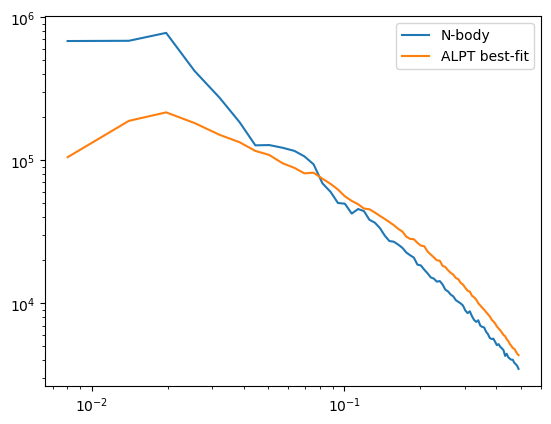

In [8]:
plt.loglog(k_bins, P_nbody, label='N-body')
plt.loglog(k_bins, P_alpt_bf, label='ALPT best-fit')
plt.legend()

In [34]:
from scipy.optimize import least_squares
k_bins = k_bins_allk[:78]
P_nbody = P_nbody_allk[:78]
theta_gal_free = {
    'alpha': (1.9230 + 0.5*1.923), # tune this ? 
    'beta': 2.0253,
    # 'dth': -0.7889,
    'rhoeps': 14.6874,
    'eps': 0.5616, 
    # 'nmean': 3.3e-4
}
theta_gal_fixed = {
    'dth': -0.7889,
    'nmean': 3.3e-4
}
# Keep RSD fixed at CMASS values ? 
theta_rsd_free = {
    'bv': 0.7289,
    'bb': 1.1652,
    'betarsd': 1.3136,
    'gamma': 0.4944
}
param_names = list(theta_gal_free.keys()) + list(theta_rsd_free.keys())
theta_init = np.array(list(theta_gal_free.values()) + list(theta_rsd_free.values()))
# param_names = list(theta_gal_free.keys())
# theta_init =  np.array(list(theta_gal_free.values()) )
def run_alpt_and_measure_pk(theta_gal_dict, theta_rsd_dict):
    """
    Your function that:
    1. Takes parameter dictionary
    2. Runs ALPT simulation
    3. Measures P(k)
    4. Returns P_alpt at your k_bins
    """
    
    xyz_g = CS.CSbox_galaxy(theta_gal_dict, theta_rsd_dict, outdir, silent=True)
    alpt_spec = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
    kbins_alpt_allk = alpt_spec['k']
    P_alpt_allk = alpt_spec['p0k']
    return P_alpt_allk[:78]

def residual_vector(params_array):
    """Returns vector of weighted residuals, not scalar chi-squared"""
    theta_gal_new, theta_rsd_new = params_array_to_dict(params_array)
    # theta_gal_new = params_array_to_dict(params_array)
    # Run ALPT
    P_alpt = run_alpt_and_measure_pk(theta_gal_new, theta_rsd_new)
    # P_alpt = run_alpt_and_measure_pk(theta_gal_new, theta_rsd_free)
    # Return weighted residuals as a vector
    weights = 1.0 / P_nbody
    residuals = weights * (P_nbody - P_alpt)
    
    print(f"χ² = {np.sum(residuals**2):.2f}")  # Monitor progress
    return residuals

# def params_array_to_dict(params_array):
#     """Convert parameter array to galaxy bias dictionary, combining free and fixed"""
#     theta_gal_new = {name: params_array[i] for i, name in enumerate(param_names)}
#     # Add back the fixed parameters
#     theta_gal_new.update(theta_gal_fixed)
#     return theta_gal_new

#     return theta_gal_new
def params_array_to_dict(params_array):
    """Convert parameter array back to dictionaries"""
    theta_gal_new = {name: params_array[i] for i, name in enumerate(list(theta_gal_free.keys()))}
    theta_gal_new.update(theta_gal_fixed)
    theta_rsd_new = {name: params_array[i+4] for i, name in enumerate(list(theta_rsd_free.keys()))}
    print(theta_gal_new,theta_rsd_new)
    return theta_gal_new, theta_rsd_new


def make_bounds(val, fraction=0.8):
    delta = fraction * abs(val)
    return (val - delta, val + delta)

bounds = [make_bounds(val) for val in theta_init]
# Convert bounds from list of tuples to two arrays
lower_bounds = [b[0] for b in bounds]
upper_bounds = [b[1] for b in bounds]

# Run optimization
result = least_squares(
    residual_vector,
    theta_init,
    bounds=(lower_bounds, upper_bounds),
    method='trf',  # Trust Region Reflective (good with bounds)
    ftol=1e-15,
    xtol=1e-15,
    gtol=1e-15,
    verbose=2,     # Show iteration progress
    max_nfev=50    # Max function evaluations (like maxiter)
)

# Extract best-fit
theta_gal_best, theta_rsd_best = params_array_to_dict(result.x)
print("\nBest-fit parameters:")
print("Galaxy bias:", theta_gal_best)
print("RSD:", theta_rsd_best)

{'alpha': np.float64(2.8845), 'beta': np.float64(2.0253), 'rhoeps': np.float64(14.6874), 'eps': np.float64(0.5616), 'dth': -0.7889, 'nmean': 0.00033} {'bv': np.float64(0.7289), 'bb': np.float64(1.1652), 'betarsd': np.float64(1.3136), 'gamma': np.float64(0.4944)}
-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
330541 positions in 1000 box
nbar = 0.000331
330541 positions, Ntot=330541
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---
χ² = 13.45
{'alpha': np.float64(2.8845000429823995), 'beta': np.float64(2.0253), 'rhoeps': np.float64(14.6874), 'eps': np.float64(0.5616), 'dth': -0.7889, 'nmean': 0.00033} {'bv': np.float64(0.7289), 'bb': np.float64(1.1652), 'betarsd': np.float64(1.3136), 'gamma': np.float64(0.4944)}
-->Find starting indices ...
-->Start loop over cells of the mesh ...
------------------
330772 positions in 1000 box
nbar = 0.000331
330772 positions, Ntot=330772
positions assigned to grid
p

χ² = 6.19

       1              2         3.1998e+00      2.32e-01       1.26e-06       1.46e+07 

`xtol` termination condition is satisfied.

Function evaluations 2, initial cost 3.4323e+00, final cost 3.1998e+00, first-order optimality 1.46e+07.

Best-fit parameters:

Galaxy bias: {'alpha': np.float64(2.884500141503041), 'beta': np.float64(2.025299874934371), 'rhoeps': np.float64(14.687398750020892), 'eps': np.float64(0.5616000444112161), 'dth': -0.7889, 'nmean': 0.00033}

In [28]:
# Extract best-fit
theta_gal_best = params_array_to_dict(result.x)
print("\nBest-fit parameters:")
print("Galaxy bias:", theta_gal_best)



Best-fit parameters:
Galaxy bias: {'alpha': np.float64(2.88450000290874), 'beta': np.float64(2.0253000006899238), 'rhoeps': np.float64(14.687400009803191), 'eps': np.float64(0.5616000185832994), 'dth': -0.7889, 'nmean': 0.00033}


In [35]:
result.nfev

19

In [36]:
# theta_gal_lsq = {'alpha': np.float64(2.884500141503041),
#                   'beta': np.float64(2.025299874934371), 
#                   'rhoeps': np.float64(14.687398750020892), 
#                   'eps': np.float64(0.5616000444112161), 
#                   'dth': -0.7889, 
#                   'nmean': 0.00033}
# theta_rsd_bf = theta_rsd_fixed.copy()

xyz_g = CS.CSbox_galaxy(theta_gal_best, theta_rsd_best, outdir, silent=False)
spec_bf = stats.Pk_periodic(xyz_g.T, Lbox=1000, Ngrid=256, Nmubin=20, fft='pyfftw', silent=False,rsd=2)
P_alpt_bf = spec_bf['p0k'][:78]


OM0.317OL0.683G256V1000.0_ALPTrs5.000z0.500.dat
Omega_m 0.317000
Reading input ...
Getting number counts via parametric bias ...
Number counts diagnostics (min, max, mean):  0.0 102.0 0.019715547561645508
Preparing galaxy positions ...
Sampling galaxy positions ...
-->Find starting indices ...
-->Start loop over cells of the mesh ...
apply RSD ...
------------------
330772 positions in 1000 box
nbar = 0.000331
330772 positions, Ntot=330772
positions assigned to grid
position grid FFTed
fcomb complete
--- correcting for shotnoise ---


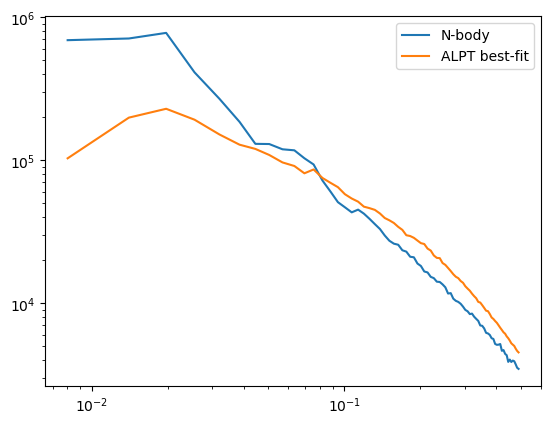

In [37]:
plt.loglog(k_bins, P_nbody, label='N-body')
plt.loglog(k_bins, P_alpt_bf, label='ALPT best-fit')
plt.legend()